<h1>KNN Classification</h1>

<h3>1. Вчитување и претпроцесирање на податоците</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/tracks_with_binary_target.csv')
data.set_index(['title'], inplace=True)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,Eminem,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,Kesha,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,Lady Gaga,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,Bruno Mars,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [3]:
data[data.columns.drop(['year', 'is_dance_pop'])].describe()

,followers,artist_popularity,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,17.029588,84.018405,118.815216,69.878067,65.037730,-5.544931,17.945951,52.562193,222.775718,15.214768,8.682209,67.777607
std,16.243704,7.961677,24.404749,16.215948,13.212029,1.771109,13.490322,22.371560,34.748892,21.457495,7.944160,14.441404
min,0.045373,52.000000,43.000000,4.000000,23.000000,-15.000000,2.000000,4.000000,134.000000,0.000000,2.900000,0.000000
25%,5.470647,80.000000,100.000000,60.000000,58.000000,-6.849750,9.000000,35.000000,200.000000,2.000000,4.000000,61.000000
50%,10.823572,85.000000,120.000000,73.000000,67.000000,-5.000000,12.000000,53.000000,219.000000,6.000000,5.880000,70.000000
75%,22.810986,89.000000,129.000000,81.150000,74.000000,-4.000000,24.250000,69.550000,238.000000,19.000000,10.000000,78.000000
max,80.746303,99.000000,206.000000,98.000000,97.000000,-2.000000,79.200000,98.000000,424.000000,99.000000,48.700000,99.000000


Бидејќи KNN алгоритмот не може да работи со категорични карактеристики изразени како вредности на низа, користам LabelEncoder за да ги шифрирам во цели броеви.Не користам OneHotEncoding бидејќи бројот на можни категории за изведувач е голем. 

Дополнително, скалирањето е критично за алгоритмот, па поради тоа дефинирам прилагодена метрика за да се користат сите атрибути, бидејќи стандардниот KNN со Евклидово растојание може да работи само со континуирани атрибути.

In [4]:
data[['artist']] = data[['artist']].apply(LabelEncoder().fit_transform)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,58,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,103,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,108,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,26,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [5]:
X, Y = data[data.columns.drop(['is_dance_pop'])], data['is_dance_pop']

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=24
)

In [7]:
scaler = MinMaxScaler()
scaler.fit(X_train[X_train.columns.drop(['artist', 'year'])])
X_train[X_train.columns.drop(['artist', 'year'])] = scaler.transform(X_train[X_train.columns.drop(['artist', 'year'])] )
X_test[X_test.columns.drop(['artist', 'year'])] = scaler.transform(X_test[X_test.columns.drop(['artist', 'year'])] )
X[X.columns.drop(['artist', 'year'])] = scaler.transform(X[X.columns.drop(['artist', 'year'])])

In [8]:
X_cont = X.drop(['artist', 'year'], axis=1)

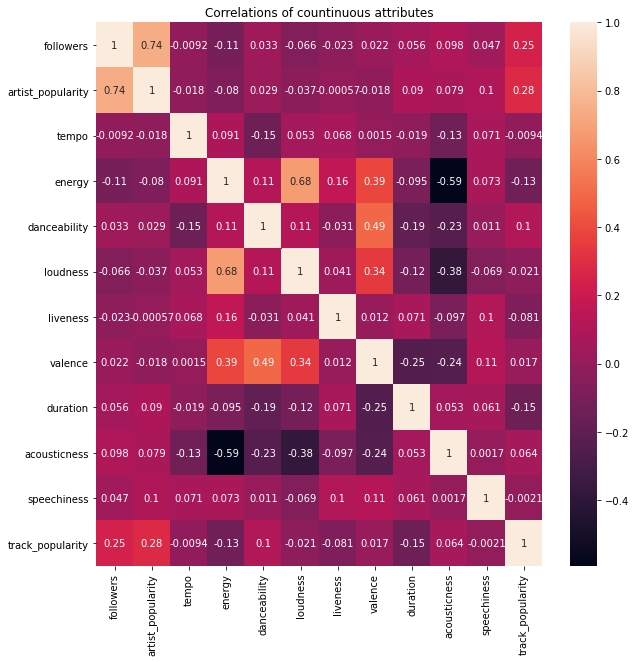

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(data[data.columns.drop(['artist', 'year', 'is_dance_pop'])].corr(), annot=True)
plt.title('Correlations of countinuous attributes')
plt.show()

<h3>2. KNN Classification</h3>

KNN не прави никакви претпоставки за податоците, така што тестирањето на корелации нема да има никаква корист.

Бидејќи податоците се од различни типови, имаме:  nominal, ordinal, interval и ration attributes, ќе дефинирам прилагодена метрика. <br>

Binary (target): is_dance_pop <br>
Nominal attributes: title(not used), artist<br>
Ordinal attributes: year (2010 - 2020)<br>
Interval: loudness<br>
Ratio: other <br>

Прилагодената метрика ги проценува номиналните променливи така што проверува дали се исти или не, за редните променливи го користи растојанието помеѓу вредностите поделени со нивниот опсег, потоа квадратот, а за континуираните променливи ја додава квадратната разлика и на крај се враќа квадратен корен од целосната сума.

In [9]:
def custom_metric(x, y):
  score = 0
  val = (x[0]!=y[0])**2 #for artist (nominal)
  score += val
  count = 0

  for xi, yi in zip(x[1:], y[1:]):
    if count == 2:
      score += (abs((xi-yi) / 9))**2 #for year (ordinal)
    else:
      score += (xi-yi)**2
    count += 1

  return np.sqrt(score)

In [10]:
def cross_validation_model(X, Y, model):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  score = cross_val_score(model, X, Y)

  return predicted, actual, score

In [12]:
errors = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine',custom_metric]

for metric in metrics:
  node = []
  for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i, metric=metric, p=3)
    if metric != metrics[-1]:
        pred_i, act_i, score_i = cross_validation_model(X_cont, Y, knn)
    else:
        pred_i, act_i, score_i = cross_validation_model(X, Y, knn)
    err = np.mean([1 if pred_i[i] != act_i[i] else 0 for i in range(len(pred_i))])
    node.append(err)
  errors.append(node)   

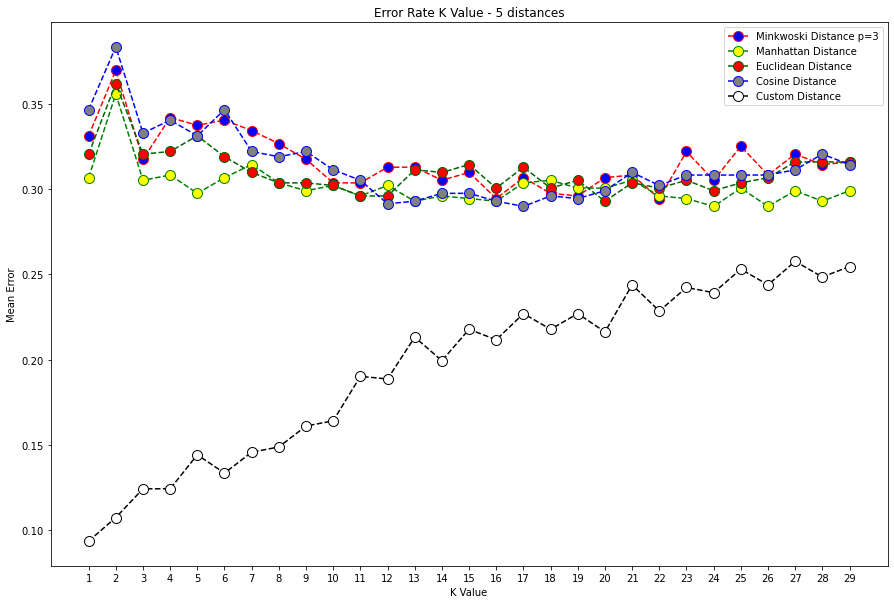

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), errors[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), errors[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), errors[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), errors[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 30), errors[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Mean Error')
plt.legend()
plt.show()

<h4>Приспособената метрика има најниска грешка за 1 сосед и таа е всушност вкупната најниска грешка во споредба со сите други метрики. Иако најмалите грешки се за еден сосед за секоја податочна точка, јас нема да изберам еден сосед бидејќи е речиси сигурно дека тоа би било претерано. Ќе направам компромис и ќе изберам 2 најблиски соседи. 
 Приспособената метрика има вкупна најниска просечна грешка во споредба со сите други метрики.</h4>

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, metric=custom_metric)
clf.fit(X_train, Y_train)
y_pred_holdout = clf.predict(X_test)

In [15]:
print(classification_report(Y_test, y_pred_holdout))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        57
           1       0.94      0.92      0.93        74

    accuracy                           0.92       131
   macro avg       0.92      0.92      0.92       131
weighted avg       0.92      0.92      0.92       131



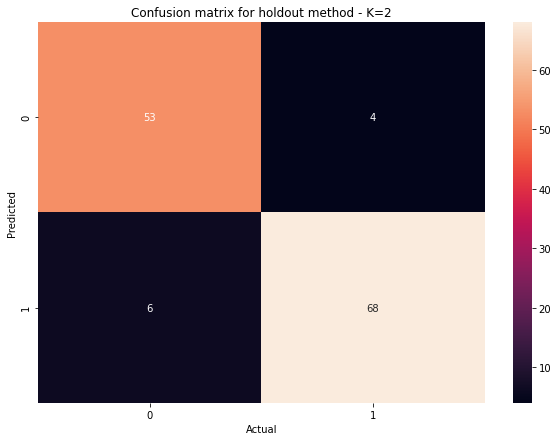

In [16]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(Y_test, y_pred_holdout), annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for holdout method - K=2')
plt.show()


КНН алгоритмот класифицирал погрешно само 10 точки кои се всушност dance-pop, предвидувајќи ги како non-dance-pop песни.

In [17]:
cv_predictions, cv_actual, cv_score = cross_validation_model(X, Y, KNeighborsClassifier(n_neighbors=2, metric=custom_metric))

In [18]:
cv_score

array([0.85496183, 0.85496183, 0.90769231, 0.87692308, 0.76153846])

In [19]:
print(classification_report(cv_actual, cv_predictions))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       315
           1       0.93      0.86      0.89       337

    accuracy                           0.89       652
   macro avg       0.89      0.89      0.89       652
weighted avg       0.90      0.89      0.89       652



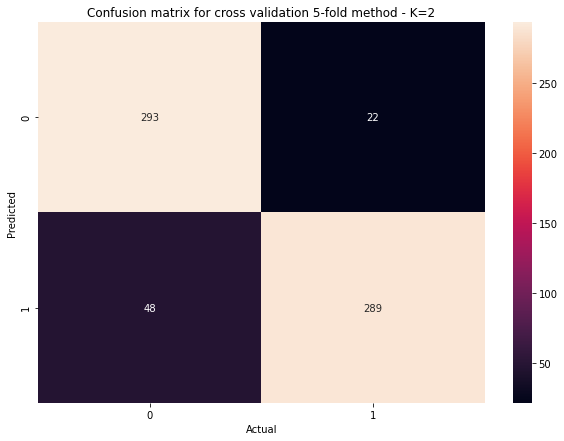

In [21]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(cv_actual, cv_predictions), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for cross validation 5-fold method - K=2')
plt.show()

Резултатите кои се добиваат за вкрстената валидација се малку пониски од резултатите на методот на задржување. Ова може да се должи на случајната поделбата. 

KNN има проблем со високи димензионални податоци, па следно кое што се тестира е како КNN функционира со PCA ,со намалена димензионалност на множеството податоци.

In [11]:
pca = PCA(5)
X_decomposed = pca.fit_transform(X_cont)

In [12]:
X_train_dec, X_test_dec, Y_train_dec, Y_test_dec = train_test_split(
    X_decomposed,
    Y,
    test_size = 0.2,
    random_state = 0
)

In [13]:
print(f'explained variance: {pca.explained_variance_ratio_}, total varinace: {np.sum(pca.explained_variance_ratio_)}')

explained variance: [0.25558697 0.17519655 0.1234875  0.09233527 0.07144358], total varinace: 0.7180498815269343


Прилагодената метрика во овој случај нема смисла, па затоа нема да ја користам.

In [14]:
errors_2 = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine']

for metric in metrics:
  node = []
  for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i, metric=metric, p=3)
    pred_i, act_i, score_i = cross_validation_model(pd.DataFrame(X_decomposed), Y, knn)
    err = np.mean([1 if pred_i[i] != act_i[i] else 0 for i in range(len(pred_i))])
    node.append(err)
  errors_2.append(node)   

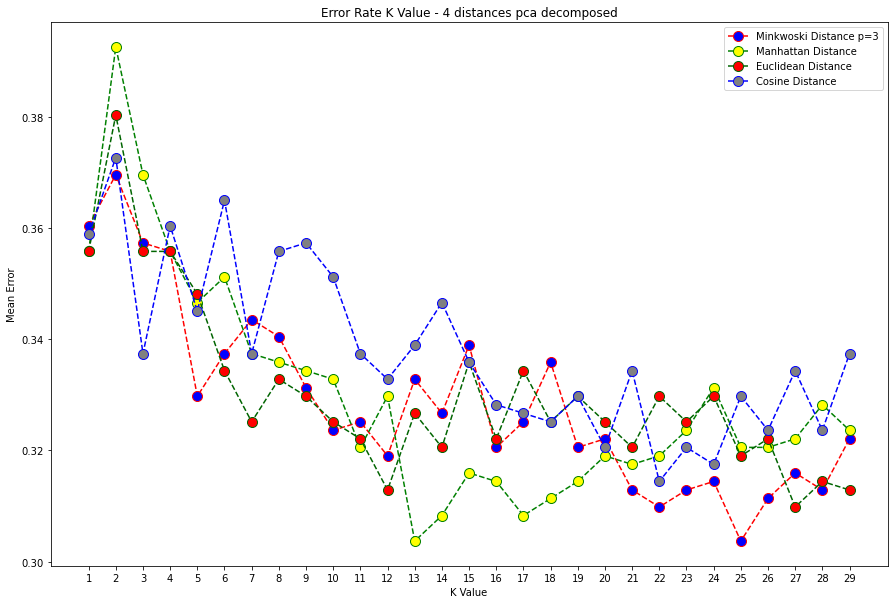

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), errors_2[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), errors_2[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), errors_2[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), errors_2[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.title('Error Rate K Value - 4 distances pca decomposed')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Mean Error')
plt.legend()
plt.show()

Можеме да забележиме дека косинусното растојание дава најлоши резултати, а од друга страна пак растојанието на Менхетен има најдобри резултати.

In [16]:
X_decomposed = pd.DataFrame(X_decomposed)

In [17]:
knn_dec = KNeighborsClassifier(n_neighbors=13, metric='manhattan')
knn_dec.fit(X_train_dec, Y_train_dec)
y_pred_dec_hold = knn_dec.predict(X_test_dec)

In [18]:
print(classification_report(Y_test_dec, y_pred_dec_hold))

              precision    recall  f1-score   support

           0       0.77      0.53      0.63        64
           1       0.66      0.85      0.74        67

    accuracy                           0.69       131
   macro avg       0.71      0.69      0.68       131
weighted avg       0.71      0.69      0.69       131



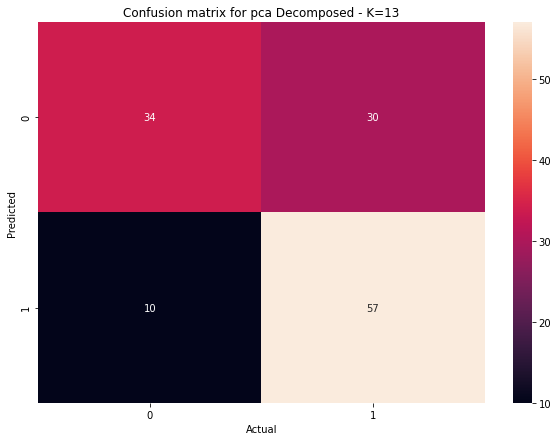

In [25]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(Y_test_dec, y_pred_dec_hold), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for pca Decomposed - K=13')
plt.show()

In [21]:
cv_predictions, cv_actual, cv_score = cross_validation_model(X_decomposed, Y, KNeighborsClassifier(n_neighbors=13, metric='manhattan'))

In [22]:
print(classification_report(cv_actual, cv_predictions))

              precision    recall  f1-score   support

           0       0.72      0.60      0.66       315
           1       0.68      0.79      0.73       337

    accuracy                           0.70       652
   macro avg       0.70      0.69      0.69       652
weighted avg       0.70      0.70      0.69       652



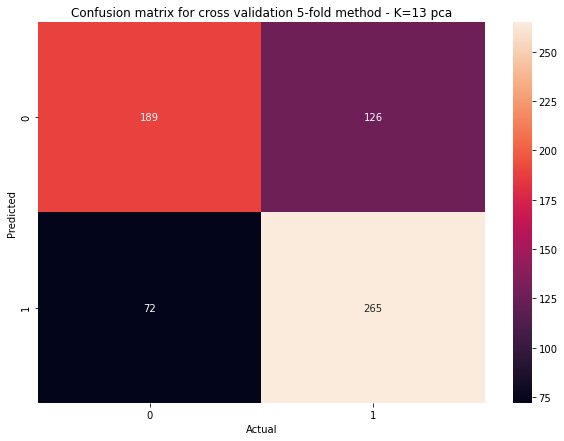

In [24]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(cv_actual, cv_predictions), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for cross validation 5-fold method - K=13 pca')
plt.show()

Можеме да заклучиме дека методот работи полошо со намалените димензионалности на карактеристики со  PCA, отколку со оригиналните карактеристики. Но, овој пат го искористив само растојанието на Менхетн наместо прилагоденото растојание. 
<p>Ова може да се должи на тоа што компонентите не опфаќаат доволно варијанса во оригиналните податоци за да се разликуваат.</p>